In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nolds
from nolitsa import lyapunov,dimension,delay,noise,data

In [43]:
%matplotlib inline
#We define a function useful to find local minimizers
def localmin(x):
    """Return all local minima from the given data set.
    Returns all local minima from the given data set.  Note that even
    "kinky" minima (which are probably not real minima) will be
    returned.
    Parameters
    ----------
    x : array
        1D scalar data set.
    Returns
    -------
    i : array
        Array containing location of all local minima.
    """
    return (np.diff(np.sign(np.diff(x))) > 0).nonzero()[0] + 1

In [44]:
#https://ourworldindata.org/coronavirus-source-data
data = pd.read_csv(r'C:\Users\javie\Covid19\datas\owid-covid-data-01-03.csv')
df =pd.DataFrame(data)

In [45]:
#Belgica
Blegiumdata=df.loc[df['location']=='Belgium']
Belgiumts=np.array(Blegiumdata.new_deaths_per_million).astype(float)[36:]/10

#Noruega
Norwaydata=df.loc[df['location']=='Norway']
Norwayts=np.array(Norwaydata.new_deaths_per_million).astype(float)[18:]/10
# Norwayts=Norwayts[3:]

#Estados Unidos
USdata=df.loc[df['location']=='United States']
USts=np.array(USdata.new_deaths_per_million).astype(float)[38:]/10
# USts=USts[1:]

#Chile
Chiledata=df.loc[df['location']=='Chile']
Chilets=np.array(Chiledata.new_deaths_per_million).astype(float)[28:]/10

#Dinamarca
Denmarkdata=df.loc[df['location']=='Denmark']
Denmarkts=np.array(Denmarkdata.new_deaths_per_million).astype(float)[41:]/10
# [11:]
# Denmarkts=Denmarkts[14:]

#Canada
Canadadata=df.loc[df['location']=='Canada']
Canadats=np.array(Canadadata.new_deaths_per_million).astype(float)[43:]/10

#Republica Checa
CzechRdata=df.loc[df['location']=='Czech Republic']
CzechRts=np.array(CzechRdata.new_deaths_per_million).astype(float)/10

#Nueva Zelanda
NZdata=df.loc[df['location']=='New Zealand']
NZts=np.array(NZdata.new_deaths_per_million).astype(float)[30:]/10

#Alemania
Alemaniadata=df.loc[df['location']=='Germany']
Alemaniats=np.array(Alemaniadata.new_deaths_per_million).astype(float)[45:]/10

#Italia
Italydata=df.loc[df['location']=='Italy']
Italiats=np.array(Italydata.new_deaths_per_million).astype(float)[21:]/10

#Solo no se encuentra republica checa, quizas con otro nombre.
#Quitamos NZ también.

#AGREGAMOS NUEVA ZELANDA, JAPON, COREA DEL SUR, AUSTRALIA.

Japandata=df.loc[df['location']=='Japan']
Japants=np.array(Japandata.new_deaths_per_million).astype(float)[22:]/10
# [1:]

SKdata=df.loc[df['location']=='South Korea']
SKts=np.array(SKdata.new_deaths_per_million).astype(float)[30:]/10
# [2:]

Australiadata=df.loc[df['location']=='Australia']
Australiats=np.array(Australiadata.new_deaths_per_million).astype(float)[35:]/10

In [46]:
Time_series=[Belgiumts,Norwayts,
             USts,Chilets,Denmarkts, 
             Alemaniats, Italiats,
             Japants, SKts, Australiats, NZts]
Countries=['Belgium', 'Norway', 'United States', 'Chile', 'Denmark', 'Germany', 'Italy', 'Japan', 'South Korea',
       'Australia','New Zealand']

In [47]:
N=11
L=250

In [48]:
TS=[]
for serie in Time_series:
    TS.append(serie[:L])

Minima of delayed mutual information = [ 7 15 19 23 29 36 38 40 45 49 61 81 92]
Autocorrelation time = 1


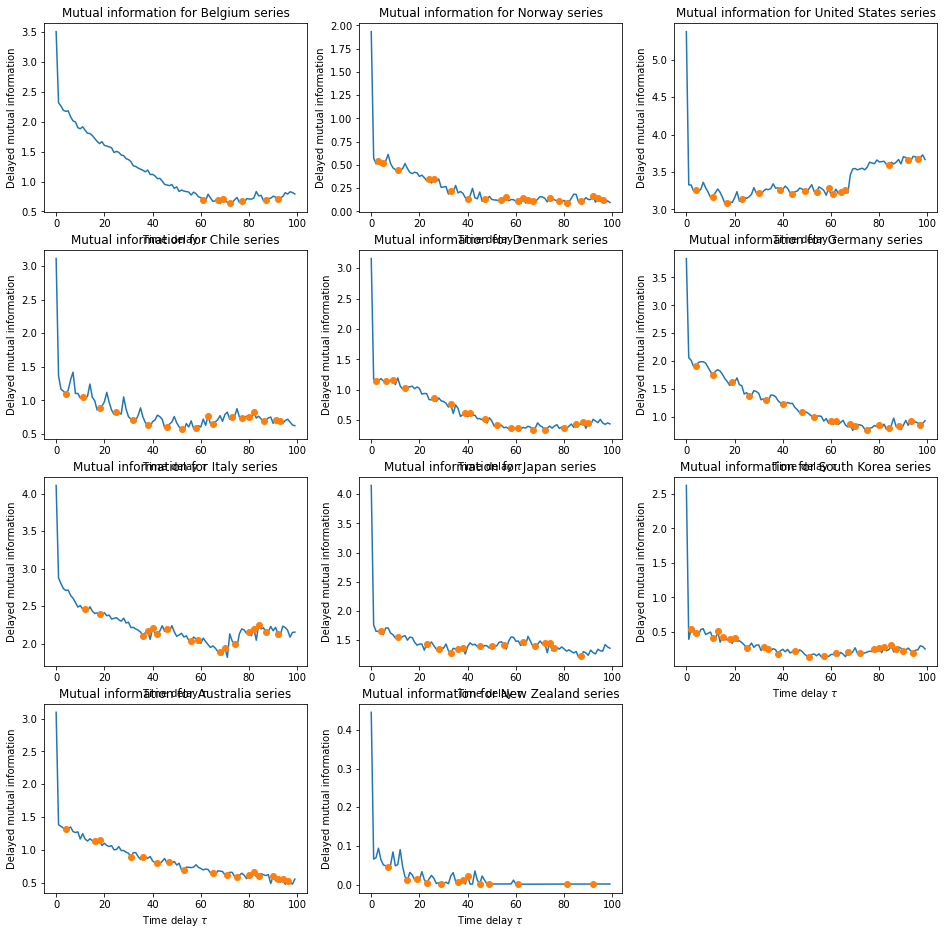

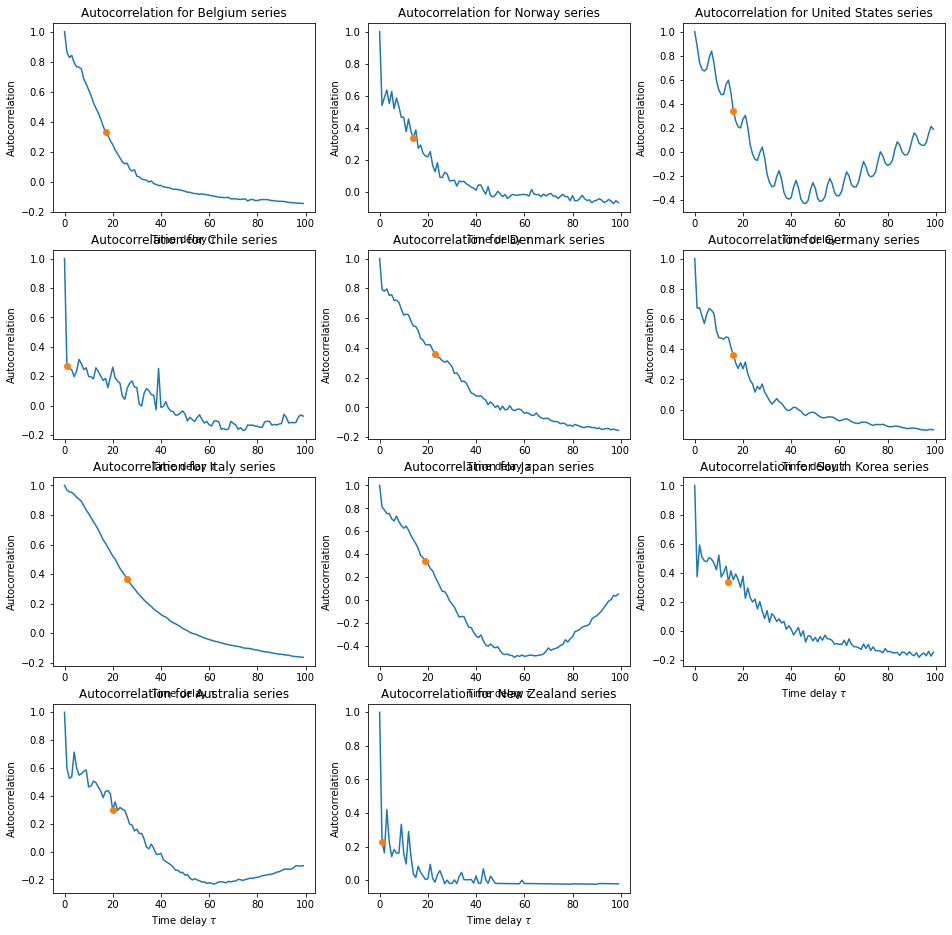

In [49]:
#Información Mutua.
# Compute autocorrelation and delayed mutual information.
lag = np.arange(100)
i_delay=np.zeros(N)
r_delay=np.zeros(N)
plt.figure(1,figsize=(16,16))
Minimals=np.zeros(N)
for j in range(N):
    x=TS[j]
    i = delay.dmi(x, maxtau=100)
    i_delay = localmin(noise.sma(i, hwin=1)) + 1
    plt.subplot(4,3,j+1)
    plt.title(r'Mutual information for ' + str(Countries[j]) +' series')
    plt.ylabel(r'Delayed mutual information')
    plt.xlabel(r'Time delay $\tau$')
    plt.plot(lag, i, i_delay, i[i_delay], 'o')
    Minimals[j]=i_delay[0]
print(r'Minima of delayed mutual information = %s' % i_delay)


#Autocorrelacion
Autocorrnumber=np.zeros(N)
plt.figure(2,figsize=(16,16))
for j in range(N):
    x=TS[j]
    r = delay.acorr(x, maxtau=100)
    r_delay = np.argmax(r < 1.0 / np.e)
    
    plt.subplot(4,3,j+1)
    plt.title(r'Autocorrelation for ' + str(Countries[j]) +' series')
    plt.xlabel(r'Time delay $\tau$')
    plt.ylabel(r'Autocorrelation')
    plt.plot(lag, r, r_delay, r[r_delay], 'o')
    Autocorrnumber[j]=r_delay
print(r'Autocorrelation time = %d' % r_delay)

In [50]:
Tau=Minimals
Theiler=Autocorrnumber*3

In [51]:
#We correct the first value of Tau
Tau[0]=5

In [52]:
Embdim=[6,6,6,8,8,7,7,7,9,11,7]

In [53]:
#We compute the mean Theiler window (45) make the following computation.
def Lyapunov(X,tauu,d,theiler,maxnumb=None):
    MLEs_nolitsa=np.zeros(1)
    LEs=lyapunov.mle_embed(X, dim=[int(d)], tau=int(tauu), window=45, maxt=100, maxnum=maxnumb)[0]
    sma=noise.sma(LEs[:40], hwin=0)
    p = np.polyfit(np.arange(len(sma)), sma,deg=1)
    xaxis = np.arange(len(sma))
    yaxis = p[1] + p[0] * xaxis
    MLEs_nolitsa[0]=p[0]
    return MLEs_nolitsa[0]*365

In [54]:
#Construyamos la lista de los diez vectores de longitudes diferentes, que sean compatibles con las fechas hasta la última 
#disponible.
Lyapse=[]
for k in range(N):
    Lyapse.append(np.zeros(len(Time_series[k])-250))

In [55]:
for j in range(1):
    for t in range(len(Lyapse[j])):
        Y=Time_series[j][t:250+t]
        Lyapse[j][t]=Lyapunov(Y,Tau[j],Embdim[j],45,180)

In [56]:
for j in range(2,4):
    for t in range(len(Lyapse[j])):
        Y=Time_series[j][t:250+t]
        Lyapse[j][t]=Lyapunov(Y,Tau[j],Embdim[j],45,200)

In [57]:
for j in range(5,6):
    for t in range(len(Lyapse[j])):
        Y=Time_series[j][t:250+t]
        Lyapse[j][t]=Lyapunov(Y,Tau[j],Embdim[j],45,200)

In [58]:
for j in range(6,7):
    for t in range(len(Lyapse[j])):
        Y=Time_series[j][t:250+t]
        Lyapse[j][t]=Lyapunov(Y,Tau[j],Embdim[j],45,160)

In [59]:
for j in range(7,8):
    for t in range(len(Lyapse[j])):
        Y=Time_series[j][t:250+t]
        Lyapse[j][t]=Lyapunov(Y,Tau[j],Embdim[j],45,160)

In [60]:
for j in range(8,9):
    for t in range(len(Lyapse[j])):
        Y=Time_series[j][t:250+t]
        Lyapse[j][t]=Lyapunov(Y,Tau[j],Embdim[j],45,160)

In [61]:
for j in range(9,10):
    for t in range(len(Lyapse[j])):
        Y=Time_series[j][t:250+t]
        Lyapse[j][t]=Lyapunov(Y,Tau[j],Embdim[j],45,200)

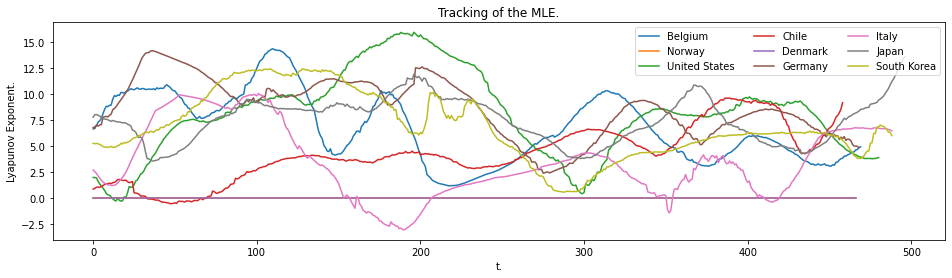

In [62]:
plt.figure(figsize=(16,4))
for k in range(9):
    plt.plot(Lyapse[k][:500])
plt.xlabel('t.')
plt.ylabel('Lyapunov Exponent.')
plt.title('Tracking of the MLE.')
plt.legend(Countries,loc='upper right',ncol=3)
plt.show()

In [63]:
FechasBelgica=Blegiumdata['date'].astype(str).values.tolist()[36:]
FechasNoruega=Norwaydata['date'].astype(str).values.tolist()[18:]
FechasUS=USdata['date'].astype(str).values.tolist()[38:]
FechasChile=Chiledata['date'].astype(str).values.tolist()[28:]
FechasDinamarca=Denmarkdata['date'].astype(str).values.tolist()[41:]
FechasCanada=Canadadata['date'].astype(str).values.tolist()[43:]
FechasCzechR=CzechRdata['date'].astype(str).values.tolist()
FechasNZ=NZdata['date'].astype(str).values.tolist()[30:]
FechasAlemania=Alemaniadata['date'].astype(str).values.tolist()[45:]
FechasItaliats=Italydata['date'].astype(str).values.tolist()[21:]
FechasJapan=Japandata['date'].astype(str).values.tolist()[22:]
FechasSK=SKdata['date'].astype(str).values.tolist()[30:]
FechasAustralia=Australiadata['date'].astype(str).values.tolist()[35:]

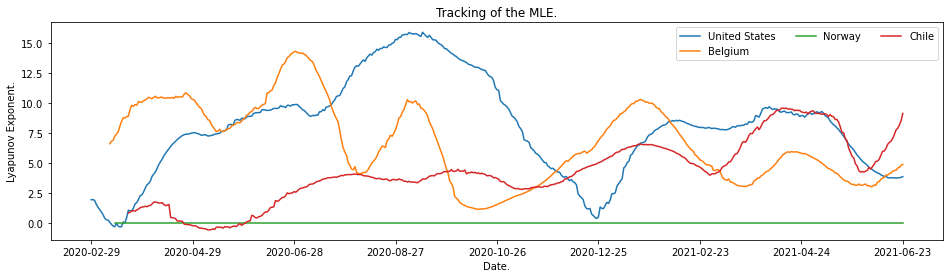

In [64]:
plt.figure(figsize=(16,4))
plt.plot(FechasUS[:len(Lyapse[2])],Lyapse[2])
plt.plot(FechasBelgica[:len(Lyapse[0])],Lyapse[0])
plt.plot(FechasNoruega[:len(Lyapse[1])],Lyapse[1])
plt.plot(FechasChile[:len(Lyapse[3])],Lyapse[3])
plt.xlabel('Date.')
plt.ylabel('Lyapunov Exponent.')
plt.title('Tracking of the MLE.')
plt.legend(['United States','Belgium', 'Norway',  'Chile'],loc='upper right',ncol=3)
plt.xticks([0,60,120,180,240,300,360,420,480])
plt.show()

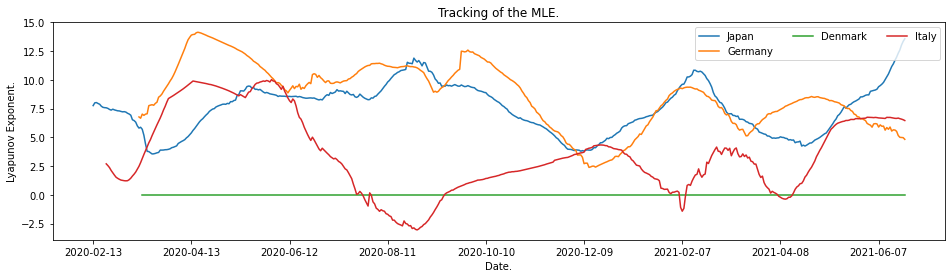

In [65]:
plt.figure(figsize=(16,4))
plt.plot(FechasJapan[:len(Lyapse[7])],Lyapse[7])
plt.plot(FechasAlemania[:len(Lyapse[5])],Lyapse[5])
plt.plot(FechasDinamarca[:len(Lyapse[4])],Lyapse[4])
plt.plot(FechasItaliats[:len(Lyapse[6])],Lyapse[6])

plt.xlabel('Date.')
plt.ylabel('Lyapunov Exponent.')
plt.title('Tracking of the MLE.')
plt.legend(['Japan','Germany','Denmark','Italy'],loc='upper right',ncol=3)
plt.xticks([0,60,120,180,240,300,360,420,480])
plt.show()

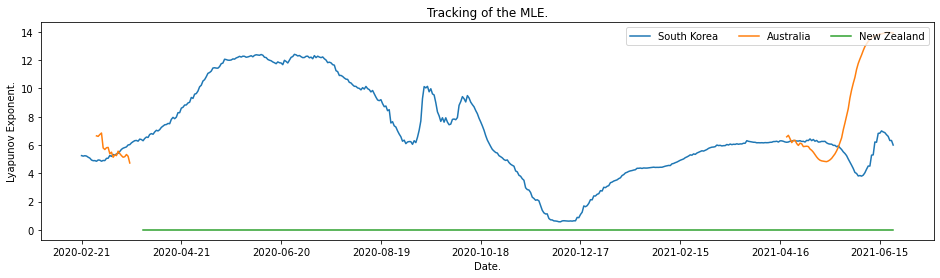

In [66]:
plt.figure(figsize=(16,4))
plt.plot(FechasSK[:len(Lyapse[8])],Lyapse[8])
plt.plot(FechasAustralia[:len(Lyapse[9])],Lyapse[9])
plt.plot(FechasNZ[:len(Lyapse[10])],Lyapse[10])
plt.xticks([0,60,120,180,240,300,360,420,480])
plt.xlabel('Date.')
plt.ylabel('Lyapunov Exponent.')
plt.title('Tracking of the MLE.')
plt.legend(['South Korea', 'Australia','New Zealand'],loc='upper right',ncol=3)
plt.show()

In [67]:
import numpy as np
Countries=['Belgium', 'Norway', 'United States', 'Chile', 'Denmark', 'Germany', 'Italy', 'Japan', 'South Korea',
       'Australia','New Zealand']
for j in range(len(Countries)):
    a = np.asarray([ Lyapse[j]])
    np.savetxt( Countries[j]+'-Deaths.csv', a, delimiter=",")